In [1]:
import tensorflow as tf 
import numpy as np 
import random 


seed_value = 42 
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception # Import Xception
import matplotlib.pyplot as plt # For potential plotting of history

# --- 1. Data Loading (Assuming you have this set up correctly from previous steps) ---
# Make sure target_size matches what Xception expects (224,224)
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2 # Your 'rural' and 'urban' classes

train_ds = tf.keras.utils.image_dataset_from_directory(
    'rural_and_urban_photos/train',
    labels='inferred',
    label_mode='categorical',
    image_size=TARGET_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
    # No validation_split here, as you have a separate val directory
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'rural_and_urban_photos/val',
    labels='inferred',
    label_mode='categorical',
    image_size=TARGET_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# It's good practice to get class names from one of the datasets
class_names = train_ds.class_names
print(f"Detected class names: {class_names}")


Found 72 files belonging to 2 classes.
Found 20 files belonging to 2 classes.
Detected class names: ['rural', 'urban']


In [3]:
# --- 2. Preprocessing Layers (Important for pre-trained models) ---
# Xception expects pixel values in the range [-1, 1].
# ImageNet models usually normalize pixels this way.
# tf.keras.applications.xception.preprocess_input does this.
# You can also define a simple Rescaling layer if your images are 0-255.
# For Xception, a direct call to preprocess_input is cleaner.

# Let's add preprocessing to the dataset pipeline for efficiency
# This layer will be applied to the input of the Xception model
preprocess_input = tf.keras.applications.xception.preprocess_input

# Data augmentation layers (optional, but highly recommended for training)
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
  # Add other relevant augmentations
])

In [4]:
def  prepare_dataset(ds,shuffle=False,augment=False): 

     # FIRST STEP: Cast the image tensor to float32
    # This ensures that subsequent mathematical operations (like division)
    # in preprocess_input work correctly.
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    # Apply data augmentation only to the training set
    if augment: 
        ds = ds.map(lambda x,y : (data_augmentation(x,training=True),y))

    # Apply preprocessing specific to Xception
    ds = ds.map(lambda x, y: (preprocess_input(x), y),
                num_parallel_calls=tf.data.AUTOTUNE) 

    # Cache and prefetch for performance
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    

In [5]:
train_ds = prepare_dataset(train_ds, augment=True)
val_ds = prepare_dataset(val_ds, augment=False)
print("Datasets prepared with float32 casting.")

# You can inspect a batch to confirm the dtype
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch dtype: {image_batch.dtype}")
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Image pixel range (example): Min={tf.reduce_min(image_batch)}, Max={tf.reduce_max(image_batch)}")

Datasets prepared with float32 casting.
Image batch dtype: <dtype: 'float32'>
Image batch shape: (32, 224, 224, 3)
Image pixel range (example): Min=-1.0, Max=1.0


In [6]:
# --- 3. Load the Pre-trained Xception Base Model ---
# include_top=False: We remove the original classification head
# weights='imagenet': Use weights pre-trained on ImageNet
# input_shape: Must match the shape of your images (224, 224, 3)
base_model = Xception(
    weights='imagenet',
    include_top=False,
    pooling='avg',
     input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

# --- 4. Freeze the Base Model Layers ---
# This is crucial for feature extraction.
# We prevent the pre-trained weights from being updated during training.
base_model.trainable = False
print("Xception base model frozen.")

Xception base model frozen.


In [7]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 111, 111, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 111, 111, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 109, 109, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 109, 109, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 109, 109, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 109, 109, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 109, 109, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 109, 109, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 55, 55, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 55, 55, 128)       │               

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
len(base_model.layers)

133

In [9]:
base_model.trainable=False

In [10]:
from keras.models import Sequential
from keras.layers import Dense 

model = Sequential() 
model.add(base_model)
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,865,578 (79.60 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [11]:
# Choose an optimizer (Adam is a good default), loss function, and metrics.
# For categorical labels (one-hot encoded), use categorical_crossentropy.
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

In [12]:
epochs = 20 
print(f"\nStarting training for {epochs} epochs...")
history = model.fit(train_ds,
                    epochs=epochs,
                    steps_per_epoch=len(train_ds),
                    validation_data=val_ds,
                    validation_steps=len(val_ds))


Starting training for 20 epochs...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5859 - loss: 0.6404 - val_accuracy: 0.7000 - val_loss: 0.5453
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9045 - loss: 0.5188 - val_accuracy: 0.7500 - val_loss: 0.4763
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9783 - loss: 0.4316 - val_accuracy: 0.9000 - val_loss: 0.4146
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9783 - loss: 0.3601 - val_accuracy: 0.9500 - val_loss: 0.3589
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.3008 - val_accuracy: 0.9500 - val_loss: 0.3109
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.2529 - val_accuracy: 1.0000 - val_loss: 0.2711
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.2150 - val_accuracy: 1.0000 - val_loss: 0.2390
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.1850 - val_accuracy: 1.000


Training complete!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step - accuracy: 1.0000 - loss: 0.0995
Validation Loss: 0.0995
Validation Accuracy: 1.0000


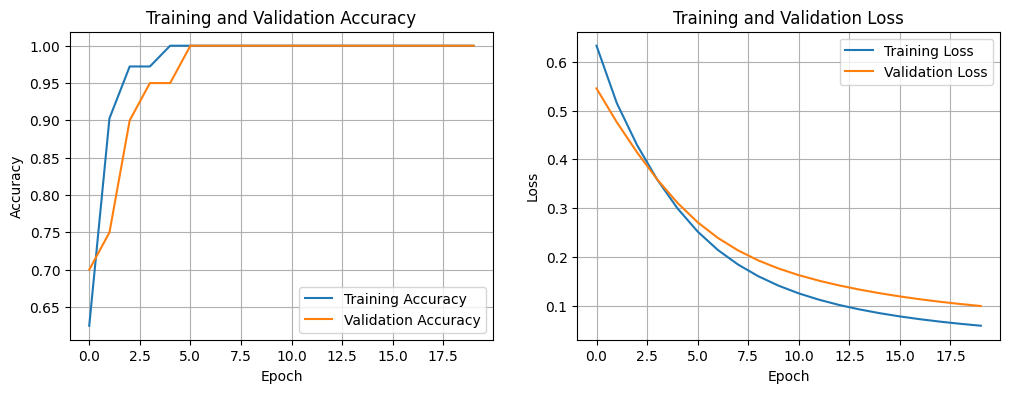

In [13]:
print("\nTraining complete!")

# --- 8. Evaluate and Plot History (Optional but Recommended) ---
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
y_pred = model.predict(val_ds)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[9.7995454e-01, 2.0045470e-02],
       [9.8920608e-01, 1.0793891e-02],
       [9.2755973e-01, 7.2440259e-02],
       [9.9959821e-01, 4.0184462e-04],
       [9.9439877e-01, 5.6012147e-03],
       [9.9938726e-01, 6.1268889e-04],
       [9.9141461e-01, 8.5853385e-03],
       [9.9566758e-01, 4.3323529e-03],
       [6.2415302e-01, 3.7584695e-01],
       [9.9440694e-01, 5.5930377e-03],
       [2.1651592e-03, 9.9783486e-01],
       [1.5820043e-04, 9.9984181e-01],
       [2.7936194e-03, 9.9720639e-01],
       [5.4343631e-03, 9.9456561e-01],
       [7.5379997e-03, 9.9246198e-01],
       [5.2719740e-03, 9.9472803e-01],
       [1.4265094e-02, 9.8573488e-01],
       [6.7632035e-03, 9.9323684e-01],
       [4.5324056e-04, 9.9954671e-01],
       [1.1258969e-03, 9.9887413e-01]], dtype=float32)

In [15]:
y_pred= np.argmax(y_pred,axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Get True Labels from val_ds ---
# Iterate through the val_ds to collect all true labels
true_labels = []
for images, labels in val_ds:
    # labels are typically one-hot encoded (categorical)
    # Convert them back to integer class indices using argmax
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

In [17]:
y_true = np.array(true_labels)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


--- Classification Report ---
              precision    recall  f1-score   support

       rural       1.00      1.00      1.00        10
       urban       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


--- Confusion Matrix ---
[[10  0]
 [ 0 10]]


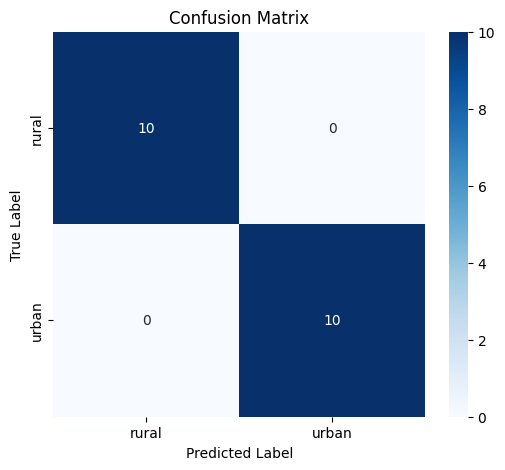

In [18]:
# --- Evaluate Model Performance ---

print("\n--- Classification Report ---")
# Get class names for better readability in the report
class_names = class_names# val_ds.class_names if hasattr(val_ds, 'class_names') else [str(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plotting the Confusion Matrix for better visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Define a path and filename for your saved model
model_save_path = 'my_xception_model.keras'

print(f"Saving model to {model_save_path}...")
model.save(model_save_path)
print("Model saved successfully!")

Saving model to my_xception_model.keras...
Model saved successfully!


In [21]:
# To load the model later:
# loaded_model = tf.keras.models.load_model(model_save_path)
# print("Model loaded successfully!")
# loaded_model.summary()
class_names

['rural', 'urban']